# Description

This project focuses on analyzing and enhancing marketing strategies. It delves into customer segmentation based on campaign responses, evaluates the impact of different traffic channels, and offers insights for optimizing unit costs. Additionally, it introduces machine learning models to predict future campaign success and delivers strategic recommendations tailored to specific customer segments or geographic locations

In [1]:
# To start working with the dataset, we will import the following libraries

import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np   # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for basic data visualization
import seaborn as sns  # Seaborn for advanced data visualization
from sklearn.cluster import KMeans  # KMeans for clustering
from sklearn.preprocessing import StandardScaler  # StandardScaler for feature scaling
from sklearn.model_selection import train_test_split  # Train-test split for model evaluation
import xgboost as xgb
import ipywidgets as widgets
from IPython.display import display, clear_output
from tkinter import Tk, filedialog
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor
# import numpy_financial as npf
# import statsmodels.api as sm
# from sklearn.preprocessing import LabelEncoder
# from sklearn.tree import DecisionTreeRegressor
# from mlxtend.frequent_patterns import apriori
# from mlxtend.frequent_patterns import association_rules
# from mlxtend.frequent_patterns import fpgrowth
import warnings  # Warnings to suppress unnecessary warnings
warnings.filterwarnings("ignore")

## Loading the date into our environment

In [3]:
def select_file(b):
    clear_output()
    root = Tk()
    root.withdraw()  # Hide the main window
    root.call('wm', 'attributes', '.', '-topmost', True)  # Raise the root to the top of all windows
    b.files = filedialog.askopenfilename(multiple=False)  # List of selected files
    path = b.files
    global df
    df = pd.read_excel(path)
    print(f'Loaded dataframe from {path}')
    display(df.head())

fileselect = widgets.Button(description="File select")
fileselect.on_click(select_file)

display(fileselect)

df.head()

Button(description='File select', style=ButtonStyle())

,ProductID,Date,CustomerID,CampaignID,ProductName,Category,Segement,Units,UnitCost,UnitPrice,TrafficChannel,Device,ZipCode,State
0,407,2019-12-31,251334,9,Maximus UM-12,Accessory,Accessory,5,59,70,Banner,Tablet,1032,Massachusetts
1,407,2019-12-31,202093,9,Maximus UM-12,Accessory,Accessory,7,59,70,Banner,Tablet,17003,Pennsylvania
2,407,2019-12-31,154671,9,Maximus UM-12,Accessory,Accessory,5,59,70,Banner,Tablet,28792,North Carolina
3,407,2019-12-31,82665,9,Maximus UM-12,Accessory,Accessory,9,59,70,Banner,Tablet,75501,Texas
4,407,2019-12-31,96975,9,Maximus UM-12,Accessory,Accessory,1,59,70,Banner,Tablet,97304,Oregon


## Understanding the Data

In [3]:
df.dtypes

ProductID                  int64
Date              datetime64[ns]
CustomerID                 int64
CampaignID                 int64
ProductName               object
Category                  object
Segement                  object
Units                      int64
UnitCost                   int64
UnitPrice                  int64
TrafficChannel            object
Device                    object
ZipCode                    int64
State                     object
dtype: object

In [4]:
df.shape

(611170, 14)

## Data Cleaning

### 1. Handling Missing Values

In [7]:
# Example: Drop rows with missing values
df_cleaned = df.dropna()


### 2. Handling Outliers

In [8]:
# Example: Remove outliers in 'Units' column using z-score
from scipy.stats import zscore
df_cleaned = df[(np.abs(zscore(df['Units'])) < 3)]


## Data Analysis

### 1. Key Metrics 

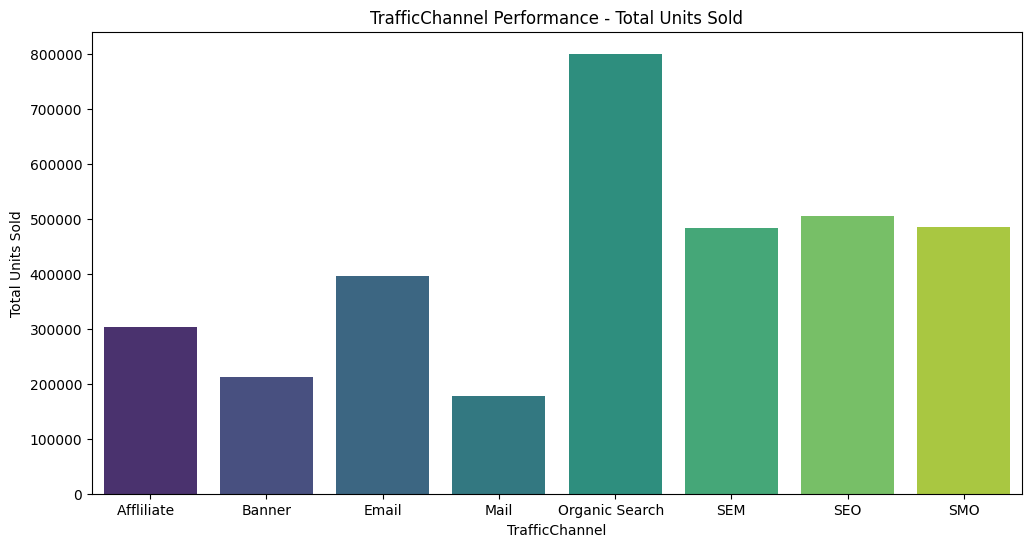

In [11]:
# 1. TrafficChannel Performance

# Group by TrafficChannel and calculate metrics
traffic_channel_metrics = df_cleaned.groupby('TrafficChannel')[['Units', 'UnitPrice']].agg({'Units': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='TrafficChannel', y='Units', data=traffic_channel_metrics, palette='viridis')
plt.title('TrafficChannel Performance - Total Units Sold')
plt.xlabel('TrafficChannel')
plt.ylabel('Total Units Sold')
plt.show()


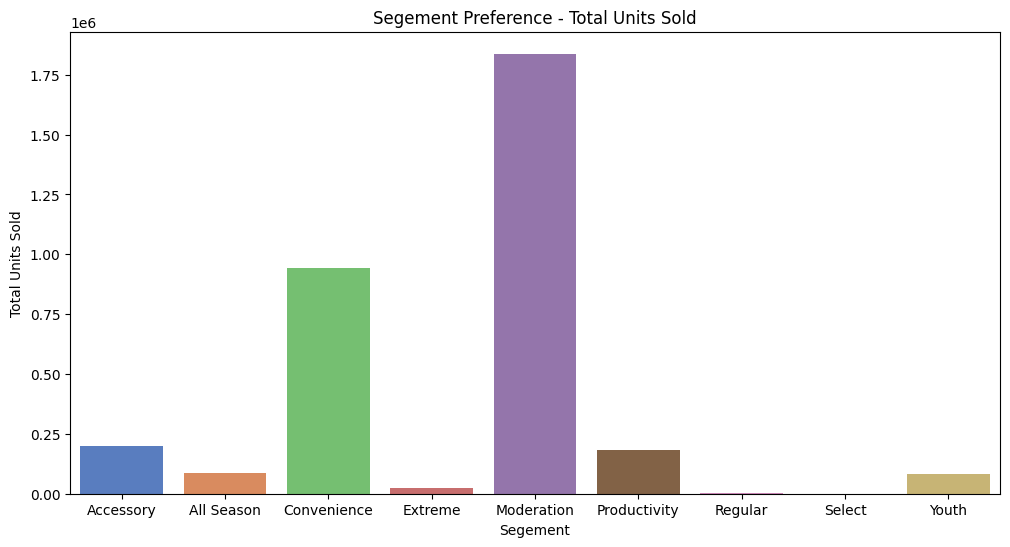

In [14]:
# 2. Segement Preference:

# Group by Segement and calculate metrics
segement_metrics = df_cleaned.groupby('Segement')[['Units', 'UnitPrice']].agg({'Units': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Segement', y='Units', data=segement_metrics, palette='muted')
plt.title('Segement Preference - Total Units Sold')
plt.xlabel('Segement')
plt.ylabel('Total Units Sold')
plt.show()


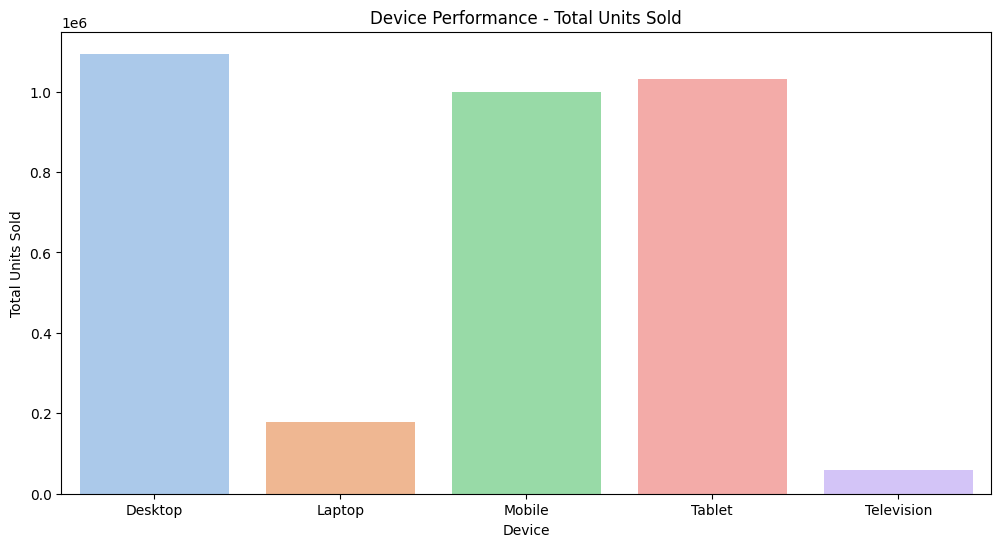

In [15]:
# 3. Device Performance:

# Group by Device and calculate metrics
device_metrics = df.groupby('Device')[['Units', 'UnitPrice']].agg({'Units': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Device', y='Units', data=device_metrics, palette='pastel')
plt.title('Device Performance - Total Units Sold')
plt.xlabel('Device')
plt.ylabel('Total Units Sold')
plt.show()


In [17]:
# Lets Map the states and add a new column called region 

# Define a dictionary that maps states to regions
state_to_region = {
    'Alabama': 'South', 'Alaska': 'West', 'Arizona': 'West', 'Arkansas': 'South', 
    'California': 'West', 'Colorado': 'West', 'Connecticut': 'Northeast', 
    'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 'Hawaii': 'West', 
    'Idaho': 'West', 'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Iowa': 'Midwest', 
    'Kansas': 'Midwest', 'Kentucky': 'South', 'Louisiana': 'South', 'Maine': 'Northeast', 
    'Maryland': 'South', 'Massachusetts': 'Northeast', 'Michigan': 'Midwest', 
    'Minnesota': 'Midwest', 'Mississippi': 'South', 'Missouri': 'Midwest', 
    'Montana': 'West', 'Nebraska': 'Midwest', 'Nevada': 'West', 'New Hampshire': 'Northeast', 
    'New Jersey': 'Northeast', 'New Mexico': 'West', 'New York': 'Northeast', 
    'North Carolina': 'South', 'North Dakota': 'Midwest', 'Ohio': 'Midwest', 
    'Oklahoma': 'South', 'Oregon': 'West', 'Pennsylvania': 'Northeast', 
    'Rhode Island': 'Northeast', 'South Carolina': 'South', 'South Dakota': 'Midwest', 
    'Tennessee': 'South', 'Texas': 'South', 'Utah': 'West', 'Vermont': 'Northeast', 
    'Virginia': 'South', 'Washington': 'West', 'West Virginia': 'South', 
    'Wisconsin': 'Midwest', 'Wyoming': 'West'
}

# Create a new column 'Region' in the dataframe
df['Region'] = df['State'].map(state_to_region)


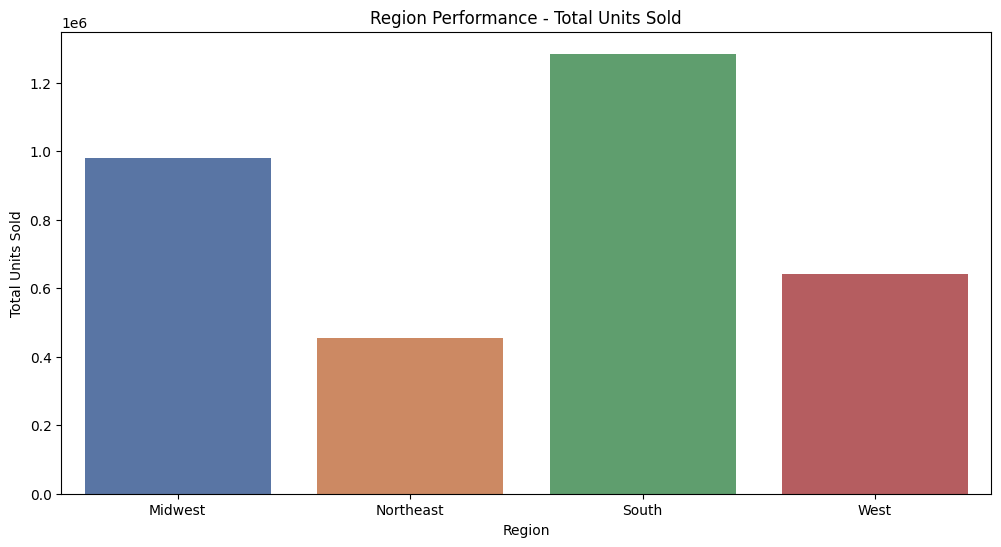

In [18]:
# 4. Region Performance:

# Group by Region and calculate metrics
region_metrics = df.groupby('Region')[['Units', 'UnitPrice']].agg({'Units': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Units', data=region_metrics, palette='deep')
plt.title('Region Performance - Total Units Sold')
plt.xlabel('Region')
plt.ylabel('Total Units Sold')
plt.show()


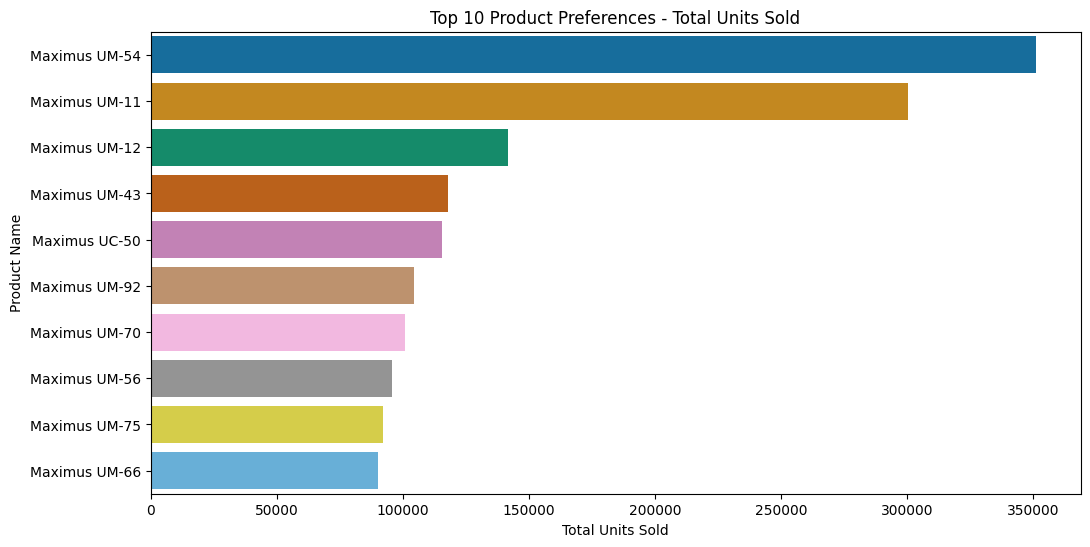

In [19]:
# 5. Product Preference:

# Group by ProductName and calculate metrics
product_metrics = df.groupby('ProductName')[['Units', 'UnitPrice']].agg({'Units': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Visualization (top 10 products by units sold)
top_products = product_metrics.nlargest(10, 'Units')
plt.figure(figsize=(12, 6))
sns.barplot(x='Units', y='ProductName', data=top_products, palette='colorblind')
plt.title('Top 10 Product Preferences - Total Units Sold')
plt.xlabel('Total Units Sold')
plt.ylabel('Product Name')
plt.show()


### 2. Key Analytics

In [20]:
# 1. Descriptive Statistics:

# Display descriptive statistics for numerical columns
descriptive_stats = df.describe()

# Display descriptive statistics for categorical columns
categorical_stats = df.describe(include='object')

# Print results
print("Descriptive Statistics for Numerical Columns:")
print(descriptive_stats)

print("\nDescriptive Statistics for Categorical Columns:")
print(categorical_stats)


Descriptive Statistics for Numerical Columns:
           ProductID                           Date     CustomerID  \
count  611170.000000                         611170  611170.000000   
mean      517.907147  2017-07-17 19:41:37.563688704  137125.513682   
min       392.000000            2015-01-01 00:00:00       1.000000   
25%       449.000000            2016-05-10 00:00:00   67737.000000   
50%       496.000000            2017-07-11 00:00:00  136285.000000   
75%       585.000000            2018-09-20 00:00:00  205672.000000   
max       691.000000            2019-12-31 00:00:00  282597.000000   
std        81.302167                            NaN   80118.485333   

          CampaignID          Units       UnitCost      UnitPrice  \
count  611170.000000  611170.000000  611170.000000  611170.000000   
mean       10.758753       5.497966      86.925476     158.339428   
min         1.000000       1.000000      16.000000      21.000000   
25%         4.000000       3.000000      56.000

In [23]:
# 2. Correlation Analysis:

# Calculate correlation between UnitCost and UnitPrice
correlation = df['UnitCost'].corr(df['UnitPrice'])
print(f"The correlation between UnitCost and UnitPrice is {correlation:.2f}")


The correlation between UnitCost and UnitPrice is 0.52


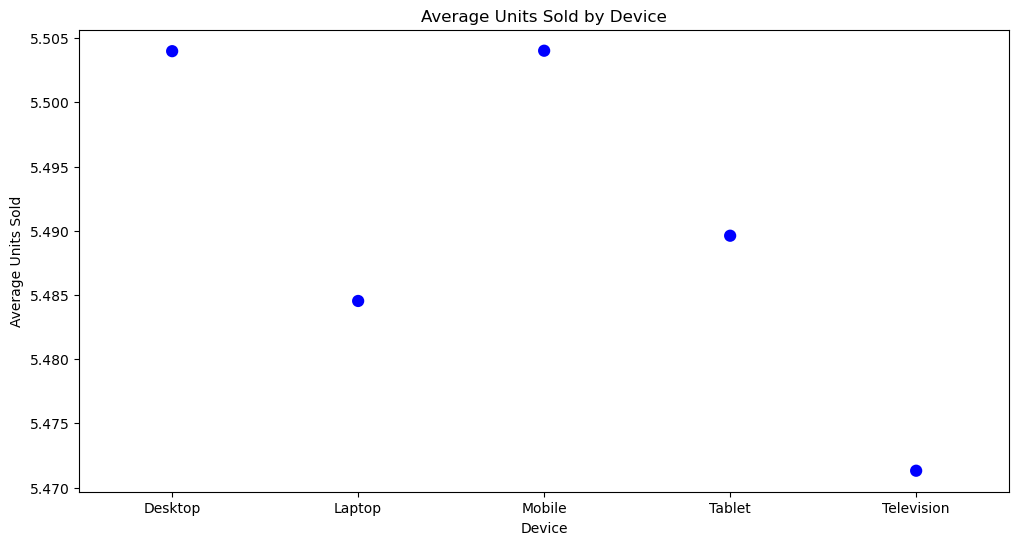

In [4]:
# Calculate correlation between Device and Units sold

# Group by Device and calculate average units sold
device_units = df.groupby('Device')['Units'].mean().reset_index()

# Visualization using point plot
plt.figure(figsize=(12, 6))
sns.pointplot(x='Device', y='Units', data=device_units, color='blue', join=False)
plt.title('Average Units Sold by Device')
plt.xlabel('Device')
plt.ylabel('Average Units Sold')
plt.show()

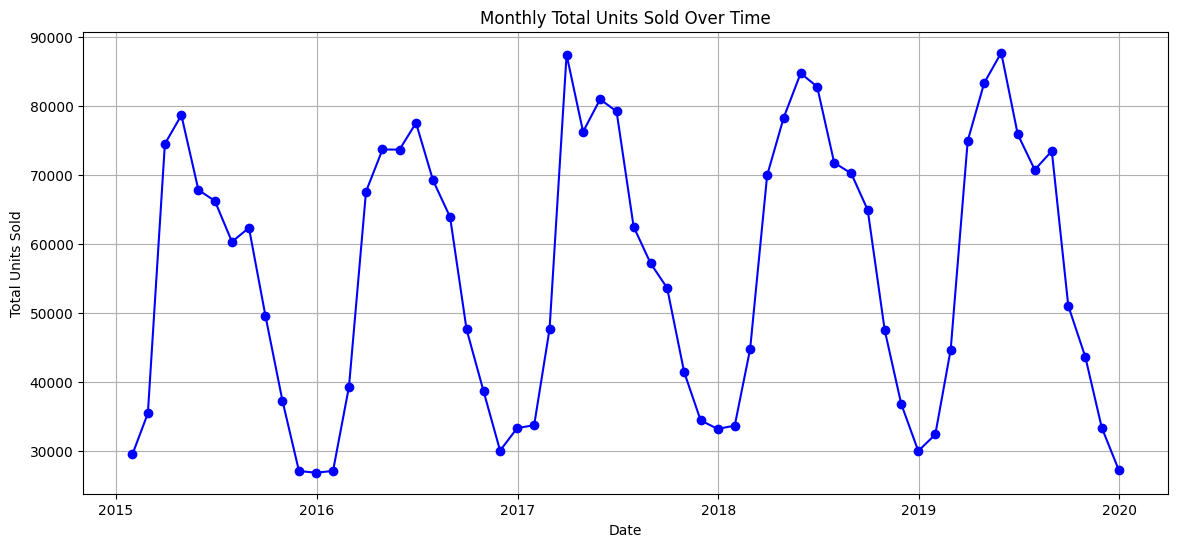

In [29]:
# 3. Time Series Analysis:

# Set the 'Date' column as the index for time series analysis
df_time_series = df.set_index('Date')

# Resample data by a specific time frequency (e.g., monthly)
df_monthly = df_time_series.resample('M').sum()

# Visualization of Time Series (e.g., Total Units Sold over time)
plt.figure(figsize=(14, 6))
plt.plot(df_monthly['Units'], marker='o', linestyle='-', color='b')
plt.title('Monthly Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.grid(True)
plt.show()


### 3. Advanced Analytics

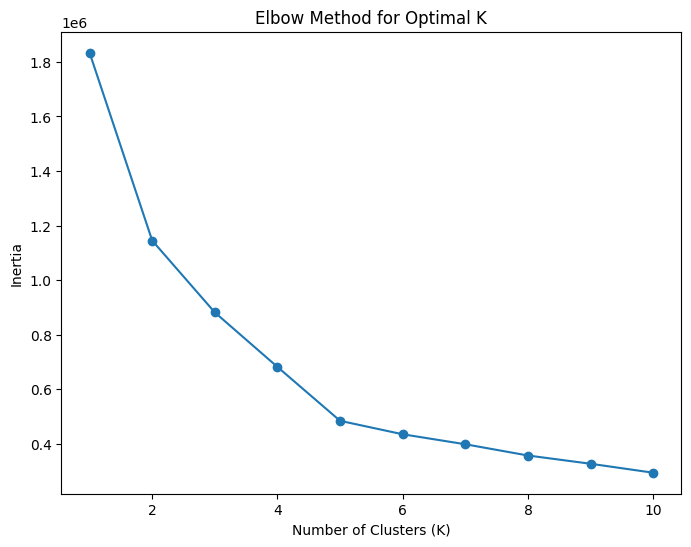

In [32]:
# 1. Customer Segmentation

# Select relevant features for clustering
features_for_clustering = df[['Units', 'UnitCost', 'UnitPrice']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Determine the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Visualization of the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [33]:
# Choose the optimal K based on the elbow method (e.g., K=3)
optimal_k = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)


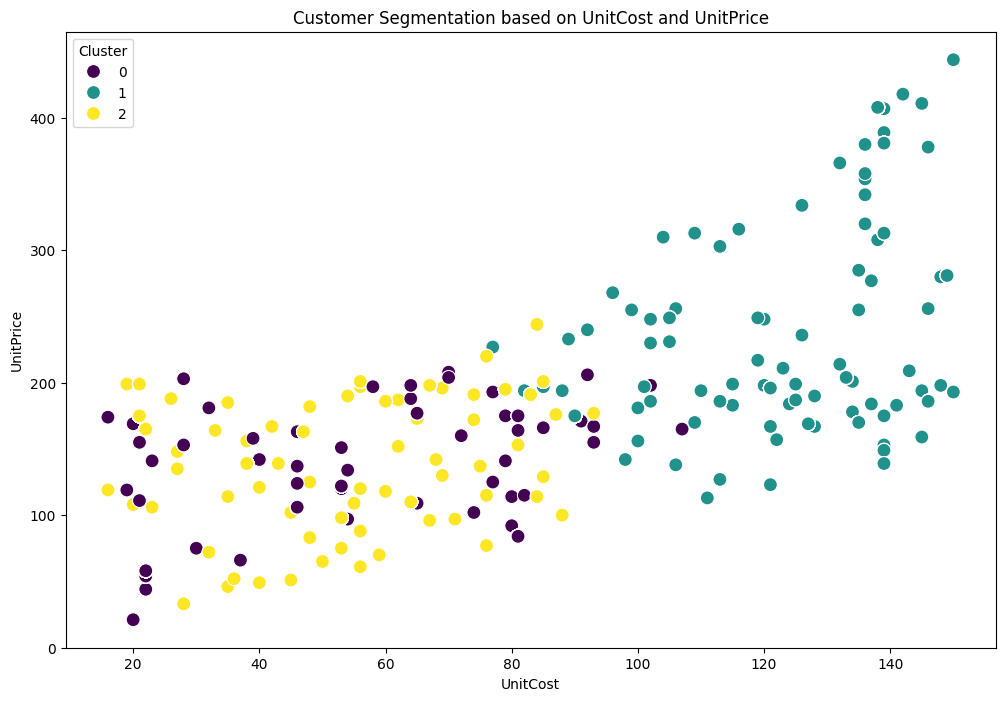

In [34]:
# Visualize customer segmentation
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UnitCost', y='UnitPrice', hue='Cluster', data=df, palette='viridis', s=100)
plt.title('Customer Segmentation based on UnitCost and UnitPrice')
plt.xlabel('UnitCost')
plt.ylabel('UnitPrice')
plt.show()


In [48]:
# 2. Item-Item Collaborative Filtering:


# Create a binary transaction dataset for collaborative filtering
basket = df.groupby(['CustomerID', 'ProductName'])['Units'].sum().unstack().reset_index().fillna(0).set_index('CustomerID')

# Convert quantities to binary values (1 if purchased, 0 otherwise)
basket[basket > 1] = 1

# Calculate the item-item similarity matrix
item_similarities = cosine_similarity(basket.T)
item_similarities = pd.DataFrame(item_similarities, index=basket.columns, columns=basket.columns)

# Function to get the most similar items
def get_similar_items(item, n=5):
    return item_similarities[item].sort_values(ascending=False)[:n]

# Test the function with an item
print(get_similar_items('Maximus UM-43'))

ProductName
Maximus UM-43    1.000000
Maximus UM-54    0.100722
Maximus UM-11    0.075382
Maximus UM-75    0.058597
Maximus UM-56    0.055813
Name: Maximus UM-43, dtype: float64


### 4. Machine Learning Models

In [8]:
# 1. Ensemble Methods (Gradient Boosting - XGBoost):


# Select features and target variable
X = df[['CustomerID', 'CampaignID', 'Units', 'UnitCost', 'UnitPrice']]
y = df['Units']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 100)

# Fit the model to the training set
xg_reg.fit(X_train, y_train)

# Predictions on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print feature importance
feature_importance = xg_reg.feature_importances_
for i, j in enumerate(X.columns):
    print(f'Feature Importance of {j}: {feature_importance[i]}')

# Print some predictions
print("Some predictions:")
for i in range(10):
    print(f'Prediction: {y_pred[i]}, Actual: {y_test.iloc[i]}')



Mean Squared Error: 0.3500736145583455
Feature Importance of CustomerID: 3.403451046324335e-05
Feature Importance of CampaignID: 1.2340366083662957e-05
Feature Importance of Units: 0.9999285936355591
Feature Importance of UnitCost: 8.53950041346252e-06
Feature Importance of UnitPrice: 1.6602580217295326e-05
Some predictions:
Prediction: 3.5071473121643066, Actual: 3
Prediction: 5.119030475616455, Actual: 5
Prediction: 6.685296535491943, Actual: 7
Prediction: 9.067241668701172, Actual: 10
Prediction: 6.691070556640625, Actual: 7
Prediction: 3.477186918258667, Actual: 3
Prediction: 3.5147688388824463, Actual: 3
Prediction: 3.513033628463745, Actual: 3
Prediction: 6.670936107635498, Actual: 7
Prediction: 5.101507186889648, Actual: 5


In [11]:
# 2. Deep Learning (Long Short-Term Memory - LSTM):

# Select the target variable
data = df[['Units']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

# Choose the number of time steps
n_steps = 10

# Create sequences
X, y = create_sequences(scaled_data, n_steps)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the batch size
batch_size = 32

# Create data loaders
train_data = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = Variable(inputs)
        labels = Variable(labels)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Convert the model to evaluation mode
model.eval()

# Predictions on the test set
with torch.no_grad():
    test_inputs = Variable(X_tensor)
    predictions = model(test_inputs)

# Convert predictions to numpy array
predictions = predictions.numpy()

# Inverse transform the predictions to get back the original scale
predictions = scaler.inverse_transform(predictions)

# Evaluate the model (MSE for example)
mse = mean_squared_error(data[n_steps:], predictions)
print(f'Mean Squared Error: {mse}')

# Print some predictions
print("Some predictions:")
for i in range(5):
    print(f'Prediction: {predictions[i]}, Actual: {data[n_steps+i]}')


Epoch [1/10], Loss: 0.11193192005157471
Epoch [2/10], Loss: 0.11172807216644287
Epoch [3/10], Loss: 0.1116839125752449
Epoch [4/10], Loss: 0.11167553812265396
Epoch [5/10], Loss: 0.11168033629655838
Epoch [6/10], Loss: 0.11169217526912689
Epoch [7/10], Loss: 0.11170084029436111
Epoch [8/10], Loss: 0.11170634627342224
Epoch [9/10], Loss: 0.11171285063028336
Epoch [10/10], Loss: 0.11171510815620422
Mean Squared Error: 8.313689883504606
Some predictions:
Prediction: [5.4780254], Actual: [2]
Prediction: [5.374848], Actual: [8]
Prediction: [5.423319], Actual: [2]
Prediction: [5.3224454], Actual: [3]
Prediction: [5.180523], Actual: [2]


### 5. Natural Language Processing (NLP)

In [9]:
# 1. Topic Modeling with LDA:

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string


# Concatenate text columns into a single column
df['text_combined'] = df['ProductName'] + ' ' + df['Category'] + ' ' + df['Segement']

# Tokenize and preprocess the text
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    return tokens

df['tokens'] = df['text_combined'].apply(preprocess_text)

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Build the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


(0, '0.250*"maximus" + 0.248*"urban" + 0.204*"moderation" + 0.090*"um-11" + 0.032*"um-62"')
(1, '0.250*"maximus" + 0.219*"moderation" + 0.219*"urban" + 0.073*"um-43" + 0.064*"accessory"')
(2, '0.273*"convenience" + 0.262*"urban" + 0.251*"maximus" + 0.026*"uc-50" + 0.026*"uc-55"')
(3, '0.262*"mix" + 0.253*"maximus" + 0.180*"productivity" + 0.090*"uc-21" + 0.082*"season"')
(4, '0.341*"uc-41" + 0.241*"maximus" + 0.189*"uc-74" + 0.153*"youth" + 0.072*"uc-32"')


In [10]:
# 2. Sentiment Analysis:

nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# Concatenate text columns into a single column
df['text_combine'] = df['ProductName'] + ' ' + df['Category'] + ' ' + df['Segement']

# Calculate sentiment scores using SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text_combine'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment into positive, negative, or neutral
df['sentiment_category'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Display the results
print(df[['text_combine', 'sentiment_score', 'sentiment_category']])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


                             text_combine  sentiment_score sentiment_category
0       Maximus UM-12 Accessory Accessory              0.0            neutral
1       Maximus UM-12 Accessory Accessory              0.0            neutral
2       Maximus UM-12 Accessory Accessory              0.0            neutral
3       Maximus UM-12 Accessory Accessory              0.0            neutral
4       Maximus UM-12 Accessory Accessory              0.0            neutral
...                                   ...              ...                ...
611165        Maximus UE-19 Urban Extreme              0.0            neutral
611166     Maximus UM-01 Urban Moderation              0.0            neutral
611167     Maximus UM-11 Urban Moderation              0.0            neutral
611168    Maximus UC-01 Urban Convenience              0.0            neutral
611169    Maximus UC-69 Urban Convenience              0.0            neutral

[611170 rows x 3 columns]
